In [35]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from capoptix.data_loader import DataLoader

from capoptix.energymarkets.wholesale_energy_markets import RTM
from capoptix.nodal_price_generator import NodalPriceGenerator

from capoptix.generation.solar import SolarGeneration
from capoptix.generation.wind import WindGeneration
from capoptix.generation.fossils import FossilFuelGeneration
from capoptix.generation.capacity_provider import CapacityProvider

from capoptix.consumption.consumption import Consumption

from capoptix.shortfall import ShortfallAnalyzer

from capoptix.premia_model import CapacityPremiaModel 

from capoptix.utils import check_and_handle_missing_data

In [36]:
data_loader = DataLoader(filepath="NewYork_energy_data.csv")
data= data_loader.load_data()
data_loader.check_price_data()

False

In [37]:
data.columns

Index(['timestamps', 'wind_generation', 'fossil_generation', 'total', 'prices',
       'consumption', 'hour', 'day', 'month', 'year', 'minutes'],
      dtype='object')

In [38]:
data = check_and_handle_missing_data(data, columns=['prices','fossil_generation','consumption'], trendfill=True,drop_streaks=False).dropna()
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 842118 entries, 0 to 842117
Data columns (total 11 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   timestamps         842118 non-null  datetime64[ns]
 1   wind_generation    842118 non-null  float64       
 2   fossil_generation  842118 non-null  float64       
 3   total              842118 non-null  float64       
 4   prices             842118 non-null  float64       
 5   consumption        842118 non-null  float64       
 6   hour               842118 non-null  int64         
 7   day                842118 non-null  int64         
 8   month              842118 non-null  int64         
 9   year               842118 non-null  int64         
 10  minutes            842118 non-null  int64         
dtypes: datetime64[ns](1), float64(5), int64(5)
memory usage: 70.7 MB


In [39]:
prices = RTM(data).get_market_data()

In [40]:
fossil = FossilFuelGeneration(data)
capacity_provider = CapacityProvider(data)
capacity_provider.add_source(fossil)

demand = Consumption(data)

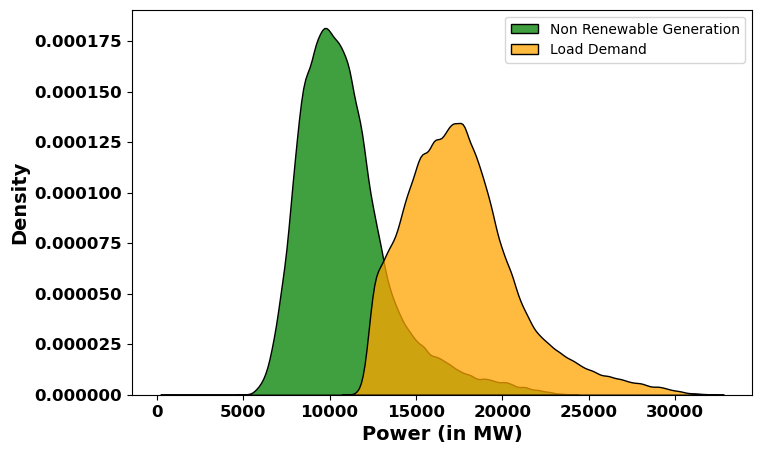

In [41]:
plt.figure(figsize=(8,5))
sns.kdeplot(capacity_provider.get_total_generation(), color= 'g',fill= True, multiple="stack")
sns.kdeplot(demand.get_consumption_data(),color = 'orange', fill= True, multiple="stack" )
plt.legend(["Non Renewable Generation", "Load Demand"])
plt.ylabel("Density", fontsize= 14, fontweight='bold')
plt.xlabel("Power (in MW)", fontsize = 14, fontweight='bold')
plt.xticks(fontsize=12, fontweight='bold')
plt.yticks(fontsize=12, fontweight='bold')
# plt.grid()
plt.show()

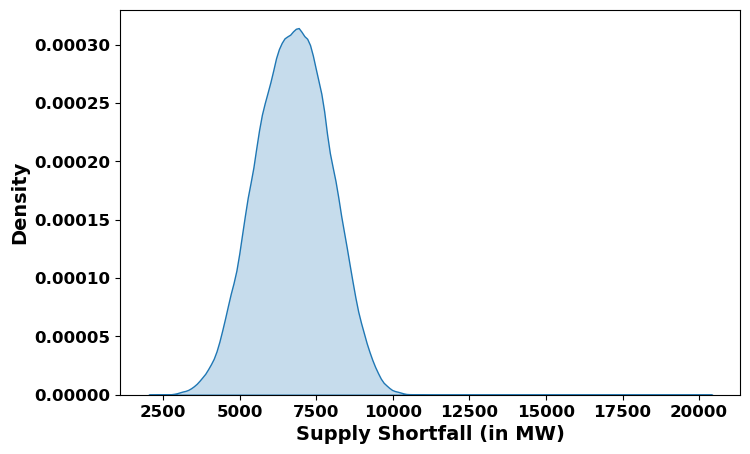

In [42]:
shortfall = ShortfallAnalyzer(capacity_provider, demand).shortfall_data
shortfall_normalized = ShortfallAnalyzer(capacity_provider, demand,"normal").shortfall_data


plt.figure(figsize=(8,5))
sns.kdeplot(shortfall, fill= True)
plt.ylabel("Density", fontsize= 14, fontweight='bold')
plt.xlabel("Supply Shortfall (in MW)", fontsize = 14, fontweight='bold')
plt.xticks(fontsize=12, fontweight='bold')
plt.yticks(fontsize=12, fontweight='bold')
# plt.grid()
plt.show()

<Axes: xlabel='QQ_Shortfall', ylabel='Density'>

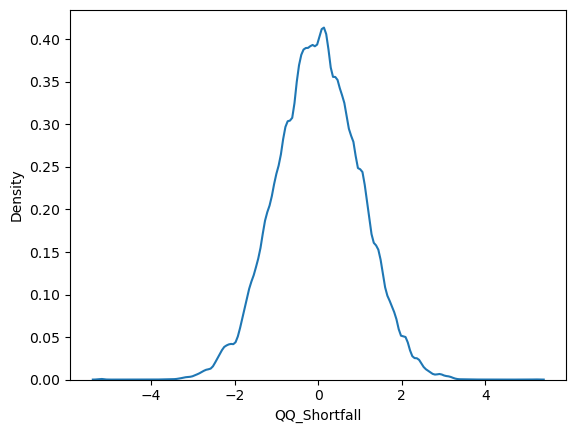

In [43]:
sns.kdeplot(shortfall_normalized)

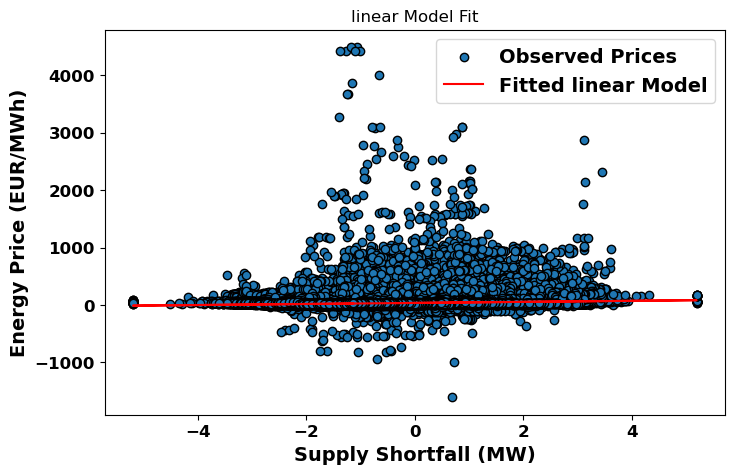

In [44]:
X=shortfall_normalized
Y=prices

nodal_price_generator = NodalPriceGenerator(X,Y)
predicted_prices=nodal_price_generator.fit_model('linear')
nodal_price_generator.plot_model_fit()

<Axes: ylabel='Density'>

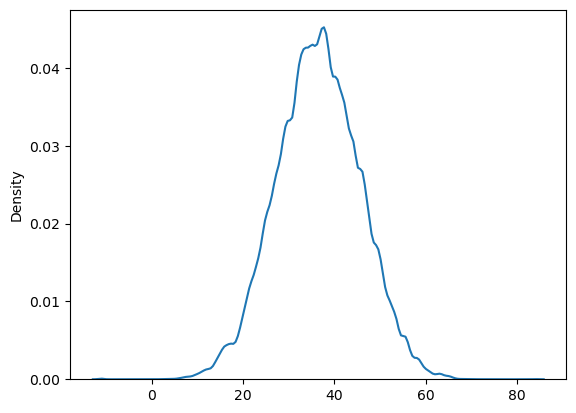

In [45]:
nodal_prices = predicted_prices
sns.kdeplot(nodal_prices)
# sns.kdeplot(prices)

In [46]:
nodal_prices.describe()

count    842118.000000
mean         36.446247
std           9.113344
min         -11.110741
25%          30.273516
50%          36.457898
75%          42.626291
max          84.046381
dtype: float64

In [52]:
nodal_prices

0         33.034938
1         33.655486
2         33.608739
3         32.819579
4         32.253682
            ...    
842113    26.865844
842114    26.190120
842115    25.331014
842116    25.774308
842117    26.058575
Length: 842118, dtype: float64

In [53]:
# estimation from raw increments
delta_t = 1
increments = np.diff(nodal_prices)
mu_est = np.nanmean(increments) / delta_t
sigma_est = (np.nanstd(increments) / np.sqrt(delta_t))


T=2  #Time to expiration : 2 years from now - time for building infrastructure
sigma = sigma_est #volatility of the wholesale energy price increments
K = np.mean(nodal_prices)       #  Strike Price
r = (2.64/100)        #  Risk-free rate - from government

wholesaleenergyprice = K   #initial wholesale energy price

tau =10*365*24 #contract period of 10 years after the expiration timeline

model=CapacityPremiaModel("bachelier")
call_price, optionp, premiums = model.premia_calculation(wholesaleenergyprice, K, r, T, tau, sigma = sigma)
print(f"the call price: {call_price}")

the call price: 531002.7433392053


In [54]:
call_price/(2*12)

22125.11430580022

In [49]:
sigma_est

0.5957925143265991

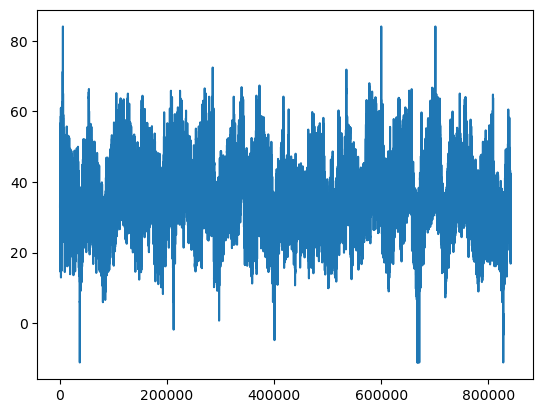

In [50]:
plt.plot(nodal_prices)

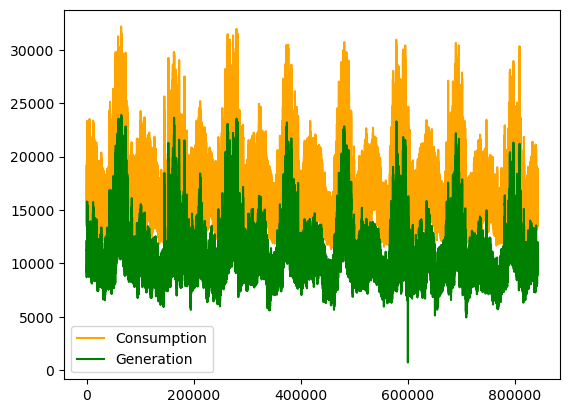

In [51]:
plt.plot(demand.get_consumption_data(),color = 'orange', label = "Consumption")
plt.plot(capacity_provider.get_total_generation(), color= 'g', label="Generation")
plt.legend()
